# Sub-graphs: multi-agent applications
* Sub-graphs allow you to create and manage different states in different parts of your graph.
* This is particularly useful for **multi-agent systems**, with teams of individual agents (aka sub-graphs) with each of them having their own state.
* In this exercise, we will use an app that does not have all of its functionalities fully implemented. **Please keep in mind that the purpose of this exercise is to demonstrate how to create and use sub-graphs within a parent graph. Therefore, completing other secondary functionalities of the app is not relevant at this time**.

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 021-subgraphs.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]
os.environ["http_proxy"] = ""
os.environ["https_proxy"] = ""

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [2]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## Building a basic multi-agent app

#### Let's consider this basic multi-agent app:
**The user submits a log describing how a student has answering a question in a school test and how it has been graded by her teacher.** For example, a log with the following fields:
 
- `id` = `"001"` → Required string.  
- `question` = `"What is Python?"` → Required string.  
- `docs` = `["doc1", "doc2"]` → Optional list with 2 items.  
- `answer` = `"Python is a programming language."` → Required string.  
- `grade` = `6` → Optional integer.  
- `grader` = `"Alice"` → Optional string.  
- `feedback` = `"Very detailed response."` → Optional string.

**Then the app performs two tasks by using two agents** (aka two sub-graphs):
* **Agent #1 provides a summary of the log.** For example: "This logs asks the student a question about the Python language".
* **Agent #2 provides a report with the eventual failures of the log.** For example: "The response of the student lacks details about how Python is different from other programming languages."

## The most critical thing to understand is how the sub-graphs and the parent graph communicate among them.
* In short, **the communication is done with over-lapping keys**:
    * **The sub-graphs can access the log provided by the parent graph**.
    * **The parent graph can access the summary and failure report provided by the sub-graphs**.

#### Let's explain how Overlapping Keys are working here
"Overlapping keys" means that different parts of the app (like the parent graph and sub-graphs) use the same names or labels to access shared information. These keys act like labels on a file or folder that everyone involved can read or update.

For example:
- The **parent graph** gives the sub-graphs a "log" with keys like `question`, `answer`, and `grade`.
- The **sub-graphs** use these same keys to access the information they need.
- After processing, the sub-graphs might add new keys like `summary` or `failure_report`, which the parent graph can then access.

In short, overlapping keys allow different parts of the app to "speak the same language" when sharing or working with data.

## Ok, let's define how the input (the log submitted by the user) should be formatted:

In [3]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

## Good. Let's explain the previous code in simple terms.

Let's explain the previous code step-by-step in simple terms with an example.

#### What does this code do?

It defines a **data structure** using Python's `TypedDict` from the `typing_extensions` module. This structure is called `Log` and is used to store information about logs in a **structured way**—like a blueprint for data.

#### Breaking it down:

1. **Importing modules:**
   ```python
   from typing_extensions import TypedDict
   from typing import List, Optional, Annotated
   ```
   - **`TypedDict`**: Allows us to define a dictionary with specific keys and types for the values.
   - **`List`**: Specifies that a value should be a list (like `[1, 2, 3]`).
   - **`Optional`**: Means the value could be **empty (None)** or could contain a value.
   - **`Annotated`**: (not used in this example) but helps add metadata to types for documentation or validation purposes.

2. **Defining the structure:**
   ```python
   class Log(TypedDict):
       id: str
       question: str
       docs: Optional[List]
       answer: str
       grade: Optional[int]
       grader: Optional[str]
       feedback: Optional[str]
   ```
   This creates a dictionary-like structure called `Log` with predefined **keys** and **value types**:
   - **`id`**: A required string (e.g., `"123"`).
   - **`question`**: A required string (e.g., `"What is Python?"`).
   - **`docs`**: An optional list (can be empty or have items like `[doc1, doc2]`).
   - **`answer`**: A required string (e.g., `"Python is a programming language."`).
   - **`grade`**: An optional integer (e.g., `10` or `None`).
   - **`grader`**: An optional string (e.g., `"John"` or `None`).
   - **`feedback`**: An optional string (e.g., `"Good answer!"` or `None`).

#### Example of how to use it:

```python
log_entry: Log = {
    "id": "001",
    "question": "What is Python?",
    "docs": ["doc1", "doc2"],
    "answer": "Python is a programming language.",
    "grade": 9,
    "grader": "Alice",
    "feedback": "Very detailed response."
}
```

In this example:  
- `id` = `"001"` → Required string.  
- `question` = `"What is Python?"` → Required string.  
- `docs` = `["doc1", "doc2"]` → Optional list with 2 items.  
- `answer` = `"Python is a programming language."` → Required string.  
- `grade` = `9` → Optional integer.  
- `grader` = `"Alice"` → Optional string.  
- `feedback` = `"Very detailed response."` → Optional string.  

## OK. Let's now prepare the first agent of our app
* This is what we previouly called the **Agent #2, that provides a report with the eventual failures of the log**.
    * For example: "The response of the student lacks details about how Python is different from other programming languages."
* The LangGraph team calls this agent "the sub-graph for Failure Analysis".

/var/folders/n3/xldbd0qd3z57kscpqjfpz06w0000gn/T/ipykernel_60833/4184074074.py:35: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  fa_builder = StateGraph(input=FailureAnalysisState,output=FailureAnalysisOutputState)


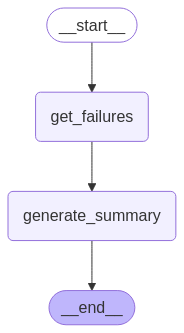

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# SEE THE EXPLANATION OF THIS CODE BELOW
# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

# This is not a very good name for the function,
# since it can create confusion with the summary
# generated by the other sub-graph.
# It would be better to call it generate_report
def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    # "Add fxn" means "Add function"—it's a note that a new function should be added to the code.
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

# PAY ATTENTION HERE: see how we create the fa_builder sub-graph
fa_builder = StateGraph(input=FailureAnalysisState,output=FailureAnalysisOutputState)

fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)

fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## There is a weird line in the previous code. Let's explain it.
In simple terms, the line of code:

```python
fa_builder = StateGraph(input=FailureAnalysisState, output=FailureAnalysisOutputState)
```

creates a "blueprint" for a mini-process or sub-graph in the **LangGraph app**. Here's how it works step by step:

#### 1. What is a `StateGraph`?
A `StateGraph` is like a flow of steps. It organizes the flow of operations (nodes) that process information (state).

#### 2. Defining the Input and Output
- **Input (`FailureAnalysisState`)**: This defines what kind of data will enter the sub-graph. In this case, the input data must include:
  - `cleaned_logs`: A list of logs.
  - `failures`: A subset of logs that indicate failures.
  - `fa_summary`: A text summary.
  - `processed_logs`: Processed log descriptions.

- **Output (`FailureAnalysisOutputState`)**: This specifies what the sub-graph will return after all processing. Here, the output will have:
  - `fa_summary`: A summary of failures.
  - `processed_logs`: A list of processed log descriptions.

#### 3. What Does This Line Achieve?
This line sets up a framework that:
- **Takes input** in the format of `FailureAnalysisState`.
- **Processes the data** through various steps (nodes).
- **Produces output** in the format of `FailureAnalysisOutputState`.

#### Analogy
Think of this as creating a conveyor belt in a factory:
- **Input**: Raw materials (logs and initial data).
- **Processing nodes**: Stations on the conveyor belt (e.g., identify failures, summarize them).
- **Output**: Finished product (a summary and processed logs).

## Let's explain the first part of the previous code in simple terms:

#### What does this code do?

It defines **data structures** and **functions** to analyze logs and identify **failures** based on the presence of a "grade" field in the logs.  

The goal is to:
1. **Filter logs that are considered failures**.  
2. **Summarize the failures**.  
3. **Track which logs were processed**.


#### Data Structures:

**`FailureAnalysisState`**
```python
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]
```
- Defines the **state** of the failure analysis process.
- It expects the following fields:
  - **`cleaned_logs`**: A list of logs that have already been pre-processed.  
  - **`failures`**: A list of logs identified as failures.  
  - **`fa_summary`**: A string summarizing the failures.  
  - **`processed_logs`**: A list of strings indicating which logs were analyzed.  


**`FailureAnalysisOutputState`**
```python
class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]
```
- Represents the **output** of the failure analysis process.  
- It simplifies the output to just:
  - **`fa_summary`**: Summary of the failures.  
  - **`processed_logs`**: List of processed logs.  


#### Functions:

**`get_failures(state)`**
```python
def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}
```
**What does it do?**  
- It **filters logs** that are considered **failures**.  
- A log is a failure if it has a **"grade"** field (which could indicate it was evaluated and graded).  

**How does it work?**  
1. It takes the input `state` which contains a list of **cleaned logs**.  
2. It **loops** through the logs (`cleaned_logs`) and selects only the ones with a **"grade"** field.  
3. It **returns** the filtered logs as **failures**.  

**Example Input:**
```python
state = {
    "cleaned_logs": [
        {"id": "001", "grade": 7},
        {"id": "002", "answer": "No grade here."},
        {"id": "003", "grade": 5},
    ]
}
```

**Output:**
```python
{"failures": [{"id": "001", "grade": 7}, {"id": "003", "grade": 5}]}
```


**`generate_summary(state)`**
```python
def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}
```

**What does it do?**  
- It **summarizes** the failures and **tracks** which logs were processed.  

**How does it work?**  
1. Takes the **failures** from the input `state`.  
2. Creates a **summary** (`fa_summary`), which in the final app would be a function, but here is hardcoded as:  
   *"Poor quality retrieval of Chroma documentation."*  
3. Generates a **list of processed logs** by appending each failure's **id** to a label like:  
   `"failure-analysis-on-log-001"`.  
4. **Returns** the summary and processed logs.

**Example Input:**
```python
state = {
    "failures": [{"id": "001"}, {"id": "003"}]
}
```

**Output:**
```python
{
    "fa_summary": "Poor quality retrieval of Chroma documentation.",
    "processed_logs": ["failure-analysis-on-log-001", "failure-analysis-on-log-003"]
}
```

#### Summary of the Workflow:

1. **Input Logs**: Start with logs stored in `cleaned_logs`.  
2. **Filter Failures**: Use `get_failures` to pick logs with a **grade**. 
3. **Generate Summary**: Use `generate_summary` to create a **summary** and **processed log IDs**.  

#### Real-life Use Case:
1. **Identify problematic logs** (those graded poorly).  
2. **Summarize the issues** (e.g., "Documentation retrieval needs improvement").  
3. **Track which logs were reviewed**.

## OK. Let's now define the second agent of our app.
* This is what we previously called **Agent #1, that provides a summary of the log.**
    * For example: "This logs asks the student a question about the Python language".
* The LangGraph team calls this agent "Subgraph for Question Summarization".

/var/folders/n3/xldbd0qd3z57kscpqjfpz06w0000gn/T/ipykernel_60833/2859328841.py:29: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  qs_builder = StateGraph(input=QuestionSummarizationState,output=QuestionSummarizationOutputState)


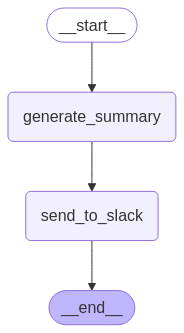

In [5]:
# SEE THE EXPLANATION OF THIS CODE BELOW
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    # "Add fxn" means "Add function"—it's a note that a new function should be added to the code.
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    # "Add fxn" means "Add function"—it's a note that a new function should be added to the code.
    # In absence of the final function, the report is mocked as "foo bar baz" by now.
    report = "foo bar baz"
    return {"report": report}

# PAY ATTENTION HERE: see how we create the qa_builder sub-graph
qs_builder = StateGraph(input=QuestionSummarizationState,output=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Let’s explain the first part of the previous code in simple terms:

#### What does this code do? 

This code defines **data structures** and **functions** for summarizing logs related to **questions** and generating a **report**.  

It:
1. **Processes logs** containing questions.  
2. **Summarizes the questions** into a brief description.  
3. **Generates a report** (mocked as `"foo bar baz"` in this case).  


#### 2. Data Structures:

**`QuestionSummarizationState`**
```python
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]
```

- Represents the **state** of the summarization process.  
- Contains:
  1. **`cleaned_logs`**: A list of logs that have been pre-processed.  
  2. **`qs_summary`**: A string summarizing the types of questions found in the logs.  
  3. **`report`**: A string containing the final report based on the summary.  
  4. **`processed_logs`**: A list of strings tracking which logs were processed.  

**`QuestionSummarizationOutputState`**
```python
class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]
```

- Represents the **output** of the summarization process.  
- Only keeps the **report** and **processed logs** as final results.  

#### Functions:

**1. `generate_summary(state)`**
```python
def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}
```

**What does it do?**  
- Creates a **summary** of the questions in the logs.  
- Tracks the **processed logs**.  

**How does it work?**  
1. Takes logs from **`cleaned_logs`** in the input `state`.  
2. In the final app it would use a function to generate the summary, but here it generates a **hardcoded summary**:  
   > *"Questions focused on usage of ChatOllama and Chroma vector store."*  
3. Tracks which logs were processed by appending `"summary-on-log-{id}"` for each log.  

**Example Input:**
```python
state = {
    "cleaned_logs": [{"id": "001"}, {"id": "002"}]
}
```

**Output:**
```python
{
    "qs_summary": "Questions focused on usage of ChatOllama and Chroma vector store.",
    "processed_logs": ["summary-on-log-001", "summary-on-log-002"]
}
```

**`send_to_slack(state)`**
```python
def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}
```

**What does it do?**  
- Pretends to **generate a report** based on the summary.  
- For now, the report is just a **placeholder text** (`"foo bar baz"`).  

**How does it work?**  
1. Takes the **summary** (`qs_summary`) from the `state`.  
2. Generates a **report** (hardcoded).  
3. **Returns** the report.

**Example Input:**
```python
state = {
    "qs_summary": "Questions focused on usage of ChatOllama and Chroma vector store."
}
```

**Output:**
```python
{
    "report": "foo bar baz"
}
```

#### Summary of the Workflow:

1. **Input Logs**: Start with logs containing questions in `cleaned_logs`.  
2. **Generate Summary**: Use `generate_summary` to create a brief description of the questions and track processed logs.  
3. **Generate Report**: Use `send_to_slack` to prepare a report (mocked).  

#### Real-life Use Case:
Imagine you’re analyzing logs:
1. **Summarize types of questions users are asking** (e.g., about specific tools like CursorAI).  
2. **Prepare a report** for review or sharing (e.g., via Slack).  

## Let's now create the parent graph
* Now, we can bring it all together.
* We will create our parent graph state defining the class `EntryGraphState`.
* And then we will add the two previous sub-graphs we created as nodes.

In [6]:
# Entry Graph
# PAY ATTENTION HERE: see the comments below
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

## Let’s explain the previous code in simple terms:

#### What does this code do?

This code defines a **data structure** called `EntryGraphState` using `TypedDict`.  

The purpose of this structure is to store the **state** (or data) that will be used and updated by the **two previous sub-graphs**:  
1. **Failure Analysis (FA) sub-graph**  
2. **Question Summarization (QS) sub-graph**  

#### Breaking it down:

**Defining the State:**

```python
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
```

- **`raw_logs`**:  
  - A **list of logs** that have not been processed yet.  
  - Each log follows the `Log` structure defined earlier (with fields like `id`, `question`, `answer`, etc.).


**Shared Field:**

```python
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
```

- **`cleaned_logs`**:  
  - A **list of logs** that have been **cleaned** or **pre-processed**.  
  - It’s **shared** between both sub-graphs (FA and QS).
  - See more about this below.


**Field for Failure Analysis (FA) sub-graph:**

```python
    fa_summary: str # This will only be generated in the FA sub-graph
```

- **`fa_summary`**:  
  - A **summary** of the **failures** generated **only** by the **Failure Analysis (FA)** sub-graph.  
  - For example:  
    > *"Poor quality retrieval of Chroma documentation."*  

**Field for Question Summarization (QS) sub-graph:**

```python
    report: str # This will only be generated in the QS sub-graph
```

- **`report`**:  
  - A **report** generated **only** by the **Question Summarization (QS)** sub-graph.  
  - For example:  
    > *"Summary of questions about ChatOllama and Chroma vector store."*  

**Shared Processed Logs Field:**

```python
    processed_logs: Annotated[List[int], add] # This will be generated in BOTH sub-graphs
```

- **`processed_logs`**:  
  - A **list of IDs** (as integers) indicating which logs have been **processed**.  
  - This field is **shared** between both sub-graphs, meaning both FA and QS can **add to it** as they process logs.  
  - Example values might look like this:  
    ```python
    [1, 2, 5]  # Logs with IDs 1, 2, and 5 have been processed
    ```

#### Purpose of the Code:
This code sets up a **state structure** that:  
1. **Stores logs** before and after processing.  
2. **Shares cleaned logs** and **processed logs** between the two sub-graphs (FA and QS).  
3. Keeps **separate outputs** (summary vs. report) for each sub-graph.  

#### Real-life Example:

**Scenario:**
Imagine you’re analyzing logs.  

- **Raw logs** contain all the original data.  
- **Cleaned logs** are logs that have been filtered or prepared for analysis.  
- **FA sub-graph** looks for **failures** and generates a **summary**.  
- **QS sub-graph** looks at **questions** and generates a **report**.  
- Both sub-graphs track which logs they’ve **processed** in `processed_logs`. 

## Why does `cleaned_logs` need a reducer if it’s only used as input for each sub-graph?

Pay attention to the following line in the previous code:

```python
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
```

The reason `cleaned_logs` requires a reducer (`operator.add`) is because the output state of each sub-graph must include all keys, even if some keys remain unchanged.  

**Since the sub-graphs run in parallel and both produce outputs with the same key (`cleaned_logs`), a reducer is necessary to combine the values from each sub-graph into a single result**.  

## Alternative Approach
Instead of having both sub-graphs output `cleaned_logs`, we could:  
1. Define a **separate output schema** for each sub-graph.  
2. Ensure these schemas use **different keys** for their outputs.  

**This approach would avoid the need for a reducer because there’s no overlap in the keys being published as outputs**.

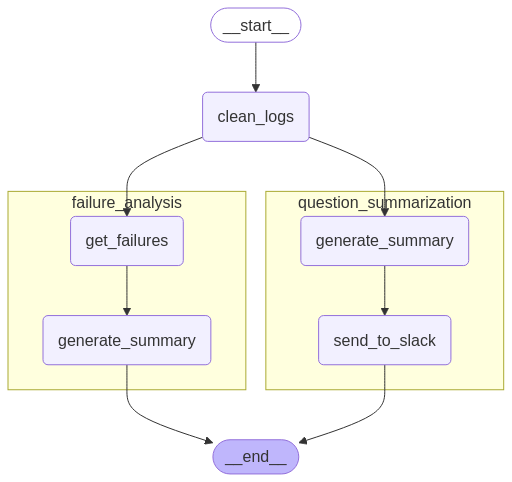

In [10]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

# PAY ATTENTION HERE: see how we create the entry_builder parent graph
entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)

# PAY ATTENTION HERE: see how we add the sub-graphs
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Let’s explain the first part of the previous code in simple terms:

#### What does this code do? 

This code defines a **state structure** and a **function** for cleaning logs.  

*Purpose:*
1. **Stores logs** in different stages—raw and cleaned.  
2. **Prepares logs** by applying a **cleaning step** (currently just passing them through unchanged).  
3. Makes the cleaned logs available for **further processing** in sub-graphs (e.g., failure analysis or question summarization).

#### The State:

**`EntryGraphState`**
```python
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str
    report: str
    processed_logs:  Annotated[List[int], add]
```

This defines the **state** (a structured dictionary) for the logs as they move through processing.  

- **`raw_logs`**:  
  - The **original logs** before any processing.  

- **`cleaned_logs`**:  
  - Logs that have been **processed** and are now ready for use in sub-graphs.  
  - These logs will be passed into both the **Failure Analysis (FA)** and **Question Summarization (QS)** sub-graphs.  

- **`fa_summary`**:  
  - A **summary of failures**, generated only by the **FA sub-graph**.  

- **`report`**:  
  - A **report of questions**, generated only by the **QS sub-graph**.  

- **`processed_logs`**:  
  - A list of IDs for logs that have been **processed** so far.  
  - Shared between both sub-graphs and can be **incrementally updated**.

#### The Function:

**`clean_logs(state)`**
```python
def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}
```

**What does it do?**  
- This function takes the input `state` and **processes the logs** to produce **cleaned logs**.  

**How does it work?**  
1. **Fetches raw logs** from the state:
   ```python
   raw_logs = state["raw_logs"]
   ```
2. **Processes the logs** (currently no actual cleaning, just copying them):
   ```python
   cleaned_logs = raw_logs
   ```
3. **Returns cleaned logs** as output:
   ```python
   return {"cleaned_logs": cleaned_logs}
   ```

#### Example Input and Output:

**Input State:**
```python
state = {
    "raw_logs": [{"id": "001", "question": "What is Python?"}],
}
```

**Output:**
```python
{
    "cleaned_logs": [{"id": "001", "question": "What is Python?"}]
}
```

#### What’s Missing?

Currently, the **cleaning step** doesn’t actually do anything—it simply copies the raw logs as cleaned logs. In real-world applications, this step might:
- **Filter out invalid data** (e.g., logs missing required fields).  
- **Normalize text** (e.g., remove extra spaces, convert to lowercase).  
- **Enrich logs** by adding extra metadata.  

#### Key Takeaways:

1. **State Management**: Tracks logs through different processing stages.
2. **Simple Cleaning Process**: Prepares logs for further analysis without modifying them yet.  
3. **Modular Design**: Makes it easy to add actual cleaning steps later.

## Let's try this multi-agent app with a simple input

In [11]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]

graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

## The previous response explained in simple terms
This response is like a **logbook** that keeps track of questions, answers, and evaluations about how well the answers match the questions. Here's a breakdown in simple terms:  

**1. `raw_logs`:**  
This is the **original data** with questions, answers, and feedback.  

- **Example 1:**  
  - **Question:** "How can I import ChatOllama?"  
  - **Answer:** "Use: `from langchain_community.chat_models import ChatOllama`."  

- **Example 2:**  
  - **Question:** "How can I use Chroma vector store?"  
  - **Answer:** "Define: `rag_chain = create_retrieval_chain(retriever, question_answer_chain)`."  
  - **Feedback:** The documents retrieved didn't fully explain how to use Chroma.  

**2. `cleaned_logs`:**  
This is a **cleaned-up version** of the original logs. Since this functionality is not developed yet in the app, it has the same information as raw_logs.  

**3. `fa_summary`:**  
A **short summary** of the problem. Since this functionality is not developed yet in the app, it has the hard-coded response: 
- "The quality of information about Chroma documentation is poor."  

**4. `report`:**  
Since this functionality is not developed yet in the app, it has the hard-coded response: 
- "foo bar baz"  

**5. `processed_logs`:**  
A **list of tasks or actions** taken based on the logs, such as:  
- Analyzing the failure in Log 2.  
- Creating summaries for Log 1 and Log 2.  

**In summary:**  
This is a **record-keeping system** for tracking how questions about a tool or software are answered, checking if the answers are good, and listing any problems or follow-ups needed.

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 002-setup.py
* In terminal, make sure you are in the directory of the file and run:
    * python 021-subgraphs.py